In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm import tqdm
import pickle
from copy import deepcopy
from scipy.ndimage import gaussian_filter1d, gaussian_filter, median_filter

In [2]:
NOTEBOOK_DIR = os.getcwd()
MODULE_DIR, _ = os.path.split(NOTEBOOK_DIR)
OUT_DIR = os.path.join(MODULE_DIR, "outputs")
sys.path.append(MODULE_DIR)

In [3]:
from longterm import load, utils
from longterm import plot as myplt
from longterm.utils import list_attr, list_fn, list_mthd, list_join
from longterm.behaviour.fictrac import get_v_th_from_fictrac
from longterm.behaviour.olfaction import conditions, plot_olfac_conditions

In [4]:
fly_dir = os.path.join(load.NAS2_DIR_JB, "210908_PR_olfac", "Fly1")
trial_dirs = load.get_trials_from_fly(fly_dir, startswith="0")[0]

In [5]:
out_infos = []
vs = []
ths = []
for trial_dir in tqdm(trial_dirs):
    trial_name = trial_dir[13:]
    out_dir = os.path.join(trial_dir, "paradigm.pkl")
    with open(out_dir, "rb") as f:
        out_info = pickle.load(f)
    out_infos.append(out_info)

    v, th = get_v_th_from_fictrac(trial_dir)
    vs.append(v)
    ths.append(th)

100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


In [6]:
v = np.concatenate(vs)
th = np.concatenate(ths)
conditions = np.concatenate([out_info["condition_list"] for out_info in out_infos])
start_indices = []
N_samples = 0
for out_info in out_infos:
    inds = np.array(out_info["start_cam_frames"]) + N_samples
    N_samples += len(out_info["t_cam"])
    start_indices = np.concatenate((start_indices, inds.astype(int)))

In [97]:
t = out_infos[0]["t_cam"]

In [334]:
conditions_merged = ["" for _ in conditions]

<IPython.core.display.Javascript object>


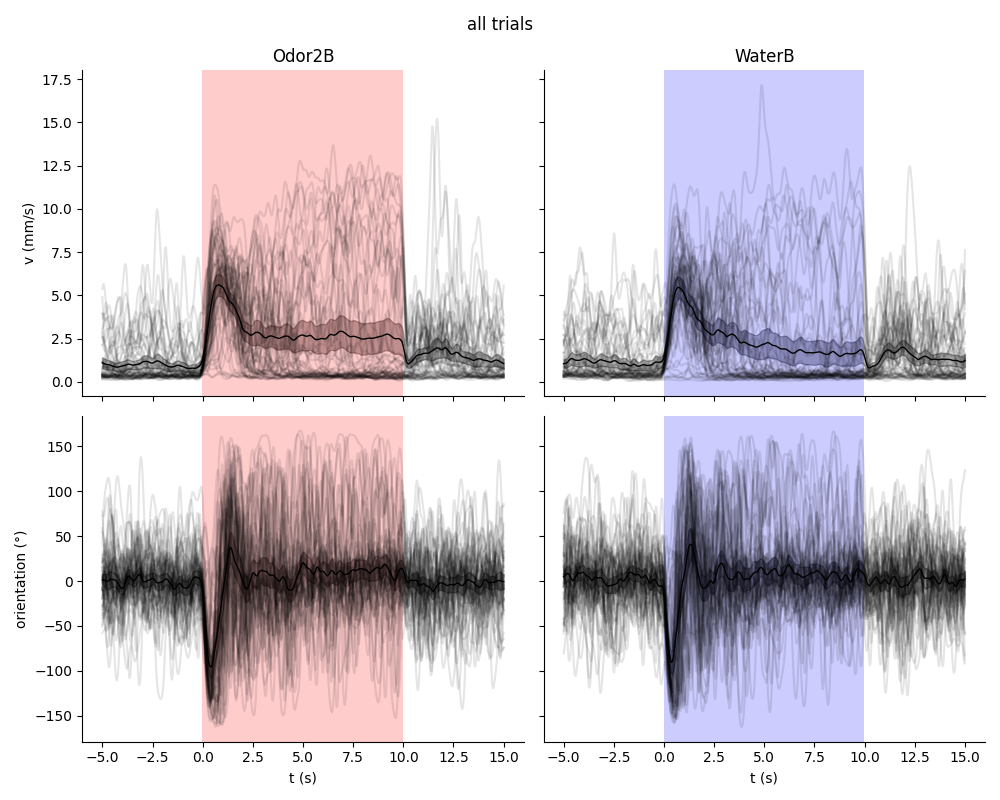

In [198]:
%matplotlib notebook
fig, condition_signals = plot_olfac_conditions(t=out_infos[0]["t_cam"], signals=(v, th),
                                                conditions=conditions,
                                                start_indices=start_indices.astype(int),
                                                trial_name="all trials",
                                                return_signals=True)

<IPython.core.display.Javascript object>


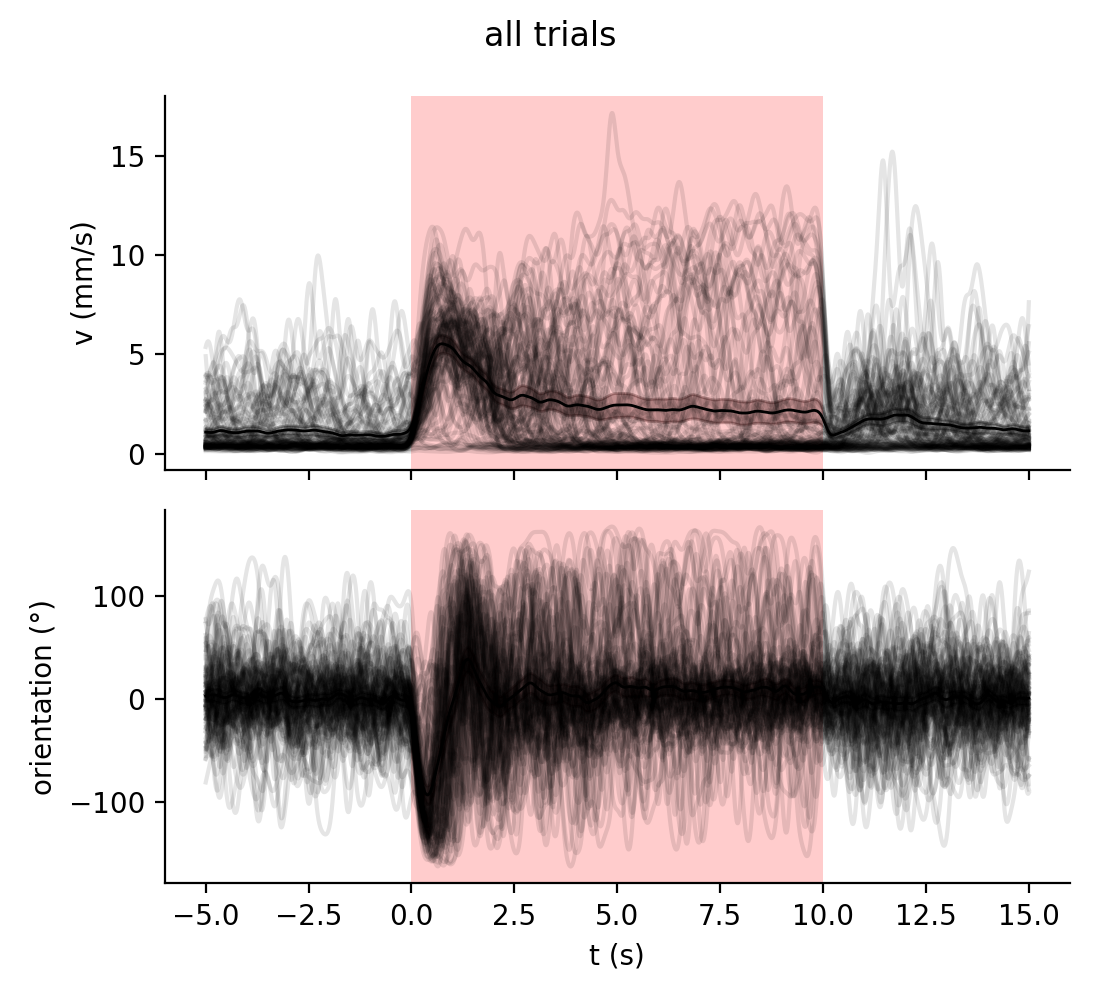

In [335]:
%matplotlib notebook
fig, condition_signals_merged = plot_olfac_conditions(t=out_infos[0]["t_cam"], signals=(v, th),
                                                conditions=conditions_merged,
                                                start_indices=start_indices.astype(int),
                                                trial_name="all trials",
                                                return_signals=True)

# interesting plot

- distribution of velocity/orientation across time

In [13]:
from sklearn.neighbors import KernelDensity

In [14]:
this_condition_signals = np.array(condition_signals[0][0])
N_traces, N_t = this_condition_signals.shape

In [353]:
signals_merged.shape

(120, 2001)

In [350]:
all_conds_v_dens = []
all_conds_v_dens_merged = []
v_plots = [np.flip(np.arange(-5, 15.01, 0.01)[:, np.newaxis]), np.flip(np.arange(-150, 151, 1)[:, np.newaxis])]
for signals, signals_merged, v_plot, bandwidth in zip(condition_signals, condition_signals_merged, v_plots, [1,5]):
    this_cond_v_dens = []
    for this_condition_signals in signals:
        this_condition_signals = np.array(this_condition_signals)
        N_traces, N_t = this_condition_signals.shape
        N_x = len(v_plot)
        all_v_dens = np.zeros((N_x, N_t))
        for i_t in tqdm(range(N_t)):
            kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(this_condition_signals[:,i_t:i_t+1])
            v_dens = np.exp(kde.score_samples(v_plot))
            all_v_dens[:, i_t] = v_dens
        this_cond_v_dens.append(all_v_dens)
    all_conds_v_dens.append(this_cond_v_dens)
    
    signals_merged = np.array(signals_merged[0])
    N_x = len(v_plot)
    N_traces, N_t = signals_merged.shape
    this_cond_v_dens_merged = np.zeros((N_x, N_t))
    for i_t in tqdm(range(N_t)):
        kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(signals_merged[:,i_t:i_t+1])
        v_dens = np.exp(kde.score_samples(v_plot))
        this_cond_v_dens_merged[:, i_t] = v_dens
    all_conds_v_dens_merged.append(this_cond_v_dens_merged)

100%|██████████| 2001/2001 [00:01<00:00, 1089.73it/s]


<IPython.core.display.Javascript object>


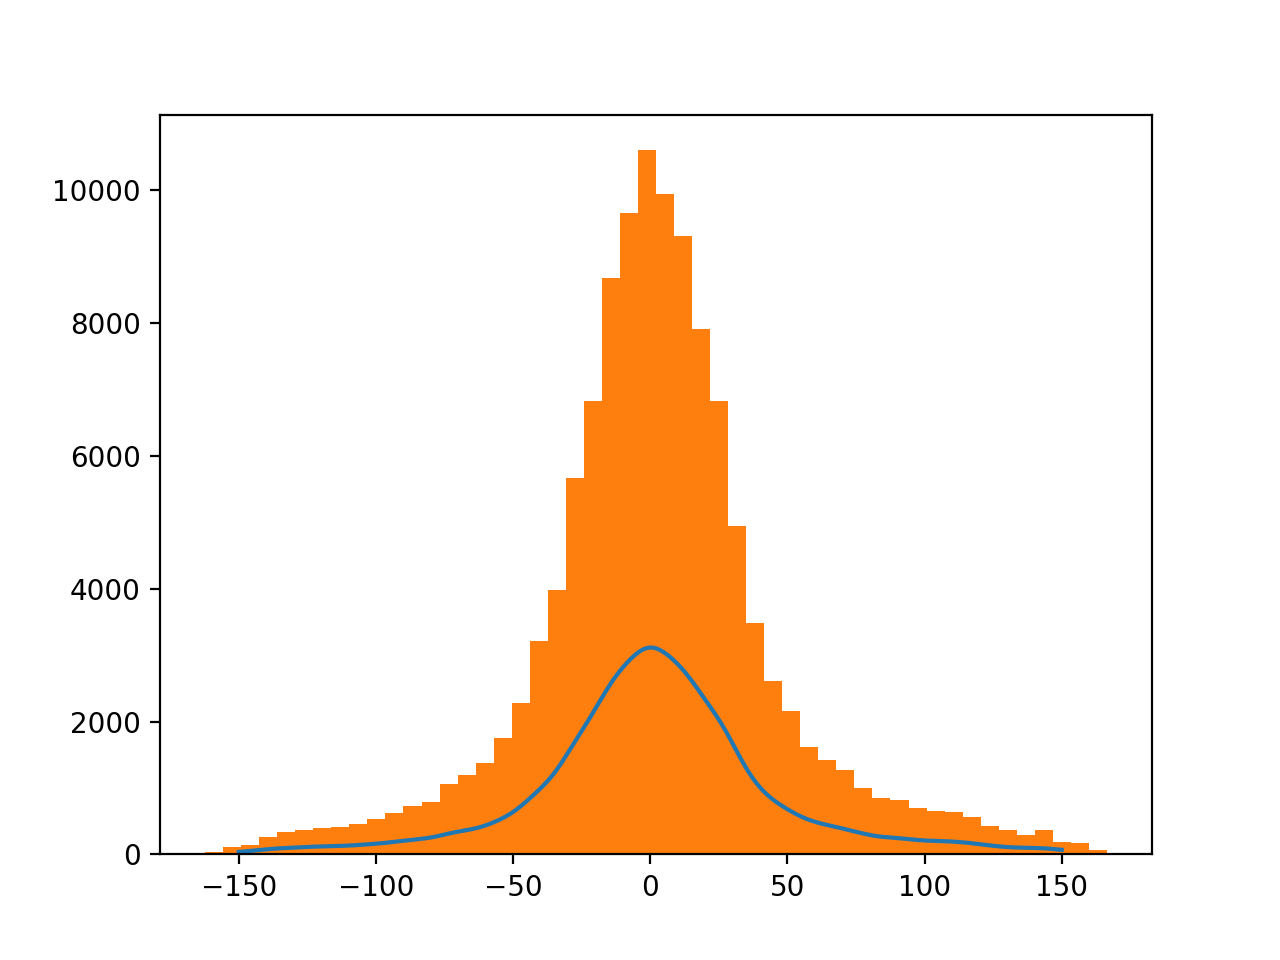

In [351]:
%matplotlib notebook
plt.plot(v_plot[:,0], np.sum(all_v_dens, axis=1)*N_traces)
_ = plt.hist(this_condition_signals.flatten(), bins=50)

In [352]:
all_conds_v_dens_merged[0].shape

(2001, 2001)

<IPython.core.display.Javascript object>


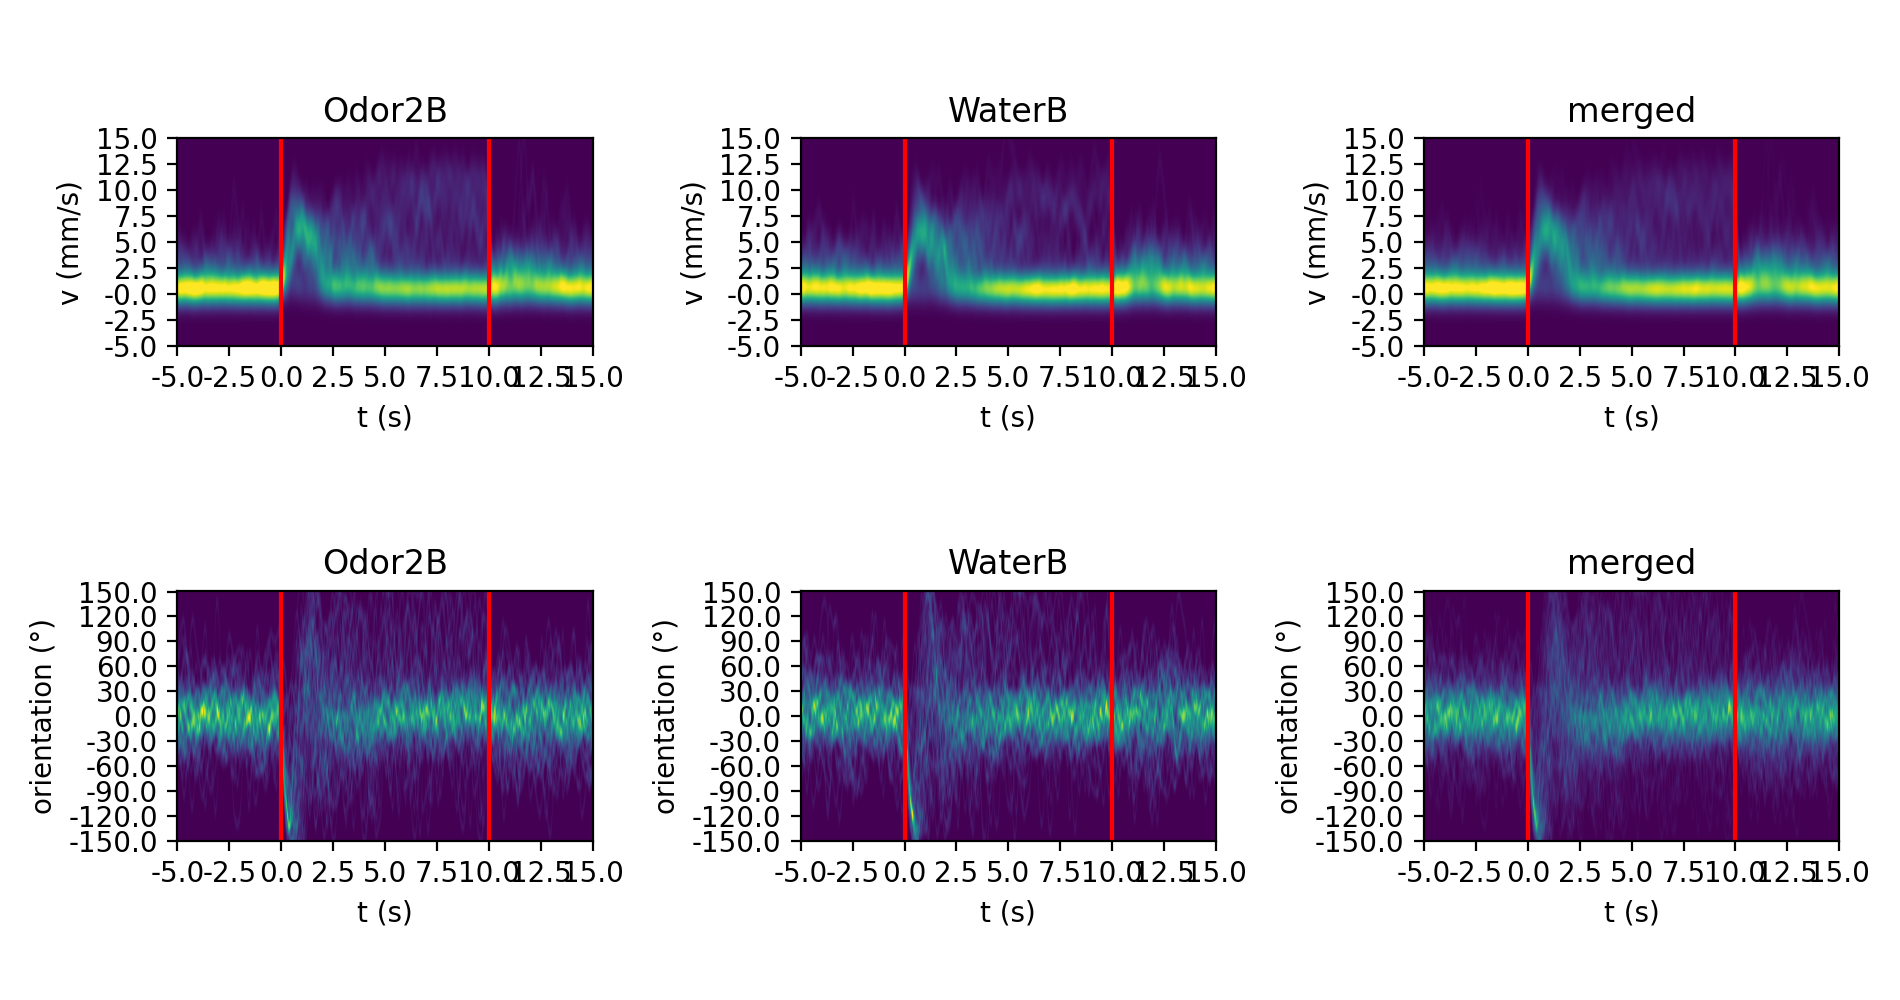

In [354]:
%matplotlib notebook
fig, axs = plt.subplots(2,3, figsize=(9.5, 5))



for i_s, (axs_, clim, aspect, ylabel, yticks, prec) in enumerate(zip(axs, [0.3, 0.025], [0.5, 4], ["v (mm/s)", "orientation (°)"], [8, 10], [0.4, 1])):
    for i_c, (ax, title) in enumerate(zip(axs_, ["Odor2B", "WaterB", "merged"])):
        if title == "merged":
            all_v_dens = all_conds_v_dens_merged[i_s]
        else:
            all_v_dens = all_conds_v_dens[i_s][i_c]
        v_plot = v_plots[i_s]
        
        ax.imshow(all_v_dens, aspect=aspect, clim=[0,clim])  # , cmap=plt.cm.get_cmap("Reds"))
        
        ax.set_xticks(np.arange(0,2001,250))
        ax.set_xticklabels(np.arange(-5,15.1,2.5))
        ax.set_xlabel("t (s)")
        
        ax.set_yticks(np.arange(len(v_plot))[::int(len(v_plot)/yticks)])
        ax.set_yticklabels(np.round(v_plot[::int(len(v_plot)/yticks),0]*prec)/prec)
        
        ax.set_ylabel(ylabel)
        ax.plot([500,500], [1,len(v_plot)-1], "r")
        ax.plot([1500,1500], [1,len(v_plot)-1], "r")

        ax.set_title(title)
        
fig.tight_layout()

## parameters of variability to be found in forward velocity

- peak velocity during first 2.5s
- duration of first walking bout (time v>1)

In [355]:
def precompute_response_distribs(velocities=None, orientations=None, filtered=None):
    if filtered is not None:
        if len(filtered) == 2:
            orientations = filtered[1]
        velocities = filtered[0]
    fs = 100  # Hz
    rest_thres = 1  # mm/s
    
    distribs = {}
    distribs["t"] = np.arange(-5, 15.01, 1/fs)
    distribs["v"] = velocities
    distribs["ori"] = orientations
    distribs["v_mean"] = np.mean(velocities, axis=0)
    distribs["v_ci"] = utils.conf_int(velocities, axis=0)
    distribs["ori_mean"] = np.mean(orientations, axis=0) if orientations is not None else None
    distribs["ori_ci"] = utils.conf_int(orientations, axis=0) if orientations is not None else None
    distribs["walking"] = velocities > rest_thres
    
    t_start = int(5.25*fs)
    diffs = np.diff(distribs["walking"].astype(int), axis=1)[:,t_start:]
    inds = []
    for i_d, d in enumerate(diffs):
        ind = np.where(d==-1)[0]
        if len(ind) and (distribs["walking"][i_d, t_start] or distribs["walking"][i_d, int(t_start+0.25*fs)]):
            inds.append(ind[0])
        else:
            inds.append(int(-0.25*fs))
    distribs["run_times"] = (np.array(inds) + 0.25*fs)/fs
    
    T = [int(5*fs), int(7.5*fs)]
    distribs["v_max"] = np.max(velocities[:, T[0]:T[1]], axis=1)
    
    return distribs

In [363]:
def plot_responses(distribs, axs, title=None, colors=None, labels=None):
    if not isinstance(distribs, list):
        distribs = [distribs]
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(distribs)]
    if labels is None:
        labels = [None for d in distribs]
        
    axs[0].set_title(title)
    
    for d,c,l in zip(distribs, colors, labels):
        myplt.plot_mu_sem(mu=d["v_mean"],
                          err=d["v_ci"],
                          x=d["t"], ax=axs[0], color=c, label=l)
        myplt.plot_mu_sem(mu=d["ori_mean"],
                          err=d["ori_ci"],
                          x=d["t"], ax=axs[1], color=c)
        
    axs[0].set_xlabel("t (s)")
    axs[0].set_ylabel("v (mm/s)")
    axs[0].legend(frameon=False)
    axs[1].set_xlabel("t (s)")
    axs[1].set_ylabel("orientation (°)")
        
        
    axs[2].imshow(distribs[0]["walking"], aspect=15, cmap=plt.cm.get_cmap("binary"))
    axs[2].set_ylabel("repetition")
    axs[2].set_xticks([])
    axs[2].set_title("walking")
    
    
    _ = [axs[3].plot(distrib["t"], np.mean(distrib["walking"], axis=0), color=c, label=l) 
         for distrib, c, l in zip(distribs, colors, labels)]
    axs[3].set_ylabel("fraction walking")
    axs[3].set_xlabel("t (s)")
    axs[3].set_ylim([0,1])
    # axs[3].legend(frameon=False)
    
    if len(distribs) > 1:
        distribs = [d for i_d, d in enumerate(distribs) if i_d]
        colors = [c for i_c, c in enumerate(colors) if i_c]
    
    axs[4].hist([d["run_times"] for d in distribs], bins=np.linspace(0,np.max(distribs[0]["run_times"]), 20), color=colors,
               label=[r"{:.2f}$\pm${:.2f}".format(np.mean(d["run_times"]), utils.conf_int(d["run_times"])) for d in distribs])
    axs[4].set_xlabel("t(s)")
    axs[4].set_title("distribution of duration of running")
    axs[4].legend(frameon=False)
    
    axs[5].hist([d["v_max"] for d in distribs], bins=np.arange(11), color=colors,
                label=[r"{:.2f}$\pm${:.2f}".format(np.mean(d["v_max"]), utils.conf_int(d["v_max"])) for d in distribs])
    axs[5].set_xlabel("v (mm/s)")
    axs[5].set_title("distribution of maximum velocity")
    axs[5].legend(frameon=False)
    
    _ = [ax.spines['right'].set_visible(False) for ax in axs.flatten()]
    _ = [ax.spines['top'].set_visible(False) for ax in axs.flatten()]
    
    

In [357]:
def filter_cond_signals(velocities, orientations=None, thres=1, i_comp=[300,500], f_comp=np.greater, f_summ=np.mean):
    if orientations is None:
        orientations = np.zeros_like(velocities)
        return_os = False
    else:
        return_os = True
    vs_new = []
    os_new = []
    for v, o in zip(velocities, orientations):
        if f_comp(f_summ(v[i_comp[0]:i_comp[1]]), thres):
            vs_new.append(v)
            os_new.append(o)
    return (np.array(vs_new), np.array(os_new)) if return_os else np.array(vs_new)

In [359]:
distribs_odour = precompute_response_distribs(np.array(condition_signals[0][0]), np.array(condition_signals[1][0]))
distribs_odour_walkbefore = precompute_response_distribs(
    filtered=filter_cond_signals(
        velocities=np.array(condition_signals[0][0]), 
        orientations=np.array(condition_signals[1][0]),
        thres=1,
        i_comp=[300,500],
        f_comp=np.greater
    ))
distribs_odour_restbefore = precompute_response_distribs(
    filtered=filter_cond_signals(
        velocities=np.array(condition_signals[0][0]), 
        orientations=np.array(condition_signals[1][0]),
        thres=1,
        i_comp=[300,500],
        f_comp=np.less_equal
    ))
distribs_odour_walkmiddle = precompute_response_distribs(
    filtered=filter_cond_signals(
        velocities=np.array(condition_signals[0][0]), 
        orientations=np.array(condition_signals[1][0]),
        thres=1,
        i_comp=[750,1000],
        f_comp=np.greater
    ))
distribs_odour_restmiddle = precompute_response_distribs(
    filtered=filter_cond_signals(
        velocities=np.array(condition_signals[0][0]), 
        orientations=np.array(condition_signals[1][0]),
        thres=1,
        i_comp=[750,1000],
        f_comp=np.less_equal
    ))

distribs_water = precompute_response_distribs(np.array(condition_signals[0][1]), np.array(condition_signals[1][1]))
distribs_water_walkbefore = precompute_response_distribs(
    filtered=filter_cond_signals(
        velocities=np.array(condition_signals[0][1]), 
        orientations=np.array(condition_signals[1][1]),
        thres=1,
        i_comp=[300,500],
        f_comp=np.greater
    ))
distribs_water_restbefore = precompute_response_distribs(
    filtered=filter_cond_signals(
        velocities=np.array(condition_signals[0][1]), 
        orientations=np.array(condition_signals[1][1]),
        thres=1,
        i_comp=[300,500],
        f_comp=np.less_equal
    ))
distribs_water_walkmiddle = precompute_response_distribs(
    filtered=filter_cond_signals(
        velocities=np.array(condition_signals[0][1]), 
        orientations=np.array(condition_signals[1][1]),
        thres=1,
        i_comp=[750,1000],
        f_comp=np.greater
    ))
distribs_water_restmiddle = precompute_response_distribs(
    filtered=filter_cond_signals(
        velocities=np.array(condition_signals[0][1]), 
        orientations=np.array(condition_signals[1][1]),
        thres=1,
        i_comp=[750,1000],
        f_comp=np.less_equal
    ))

distribs_merged = precompute_response_distribs(np.array(condition_signals_merged[0][0]), np.array(condition_signals_merged[1][0]))
distribs_merged_walkbefore = precompute_response_distribs(
    filtered=filter_cond_signals(
        velocities=np.array(condition_signals_merged[0][0]), 
        orientations=np.array(condition_signals_merged[1][0]),
        thres=1,
        i_comp=[300,500],
        f_comp=np.greater
    ))
distribs_merged_restbefore = precompute_response_distribs(
    filtered=filter_cond_signals(
        velocities=np.array(condition_signals_merged[0][0]), 
        orientations=np.array(condition_signals_merged[1][0]),
        thres=1,
        i_comp=[300,500],
        f_comp=np.less_equal
    ))
distribs_merged_walkmiddle = precompute_response_distribs(
    filtered=filter_cond_signals(
        velocities=np.array(condition_signals_merged[0][0]), 
        orientations=np.array(condition_signals_merged[1][0]),
        thres=1,
        i_comp=[750,1000],
        f_comp=np.greater
    ))
distribs_merged_restmiddle = precompute_response_distribs(
    filtered=filter_cond_signals(
        velocities=np.array(condition_signals_merged[0][0]), 
        orientations=np.array(condition_signals_merged[1][0]),
        thres=1,
        i_comp=[750,1000],
        f_comp=np.less_equal
    ))

<IPython.core.display.Javascript object>


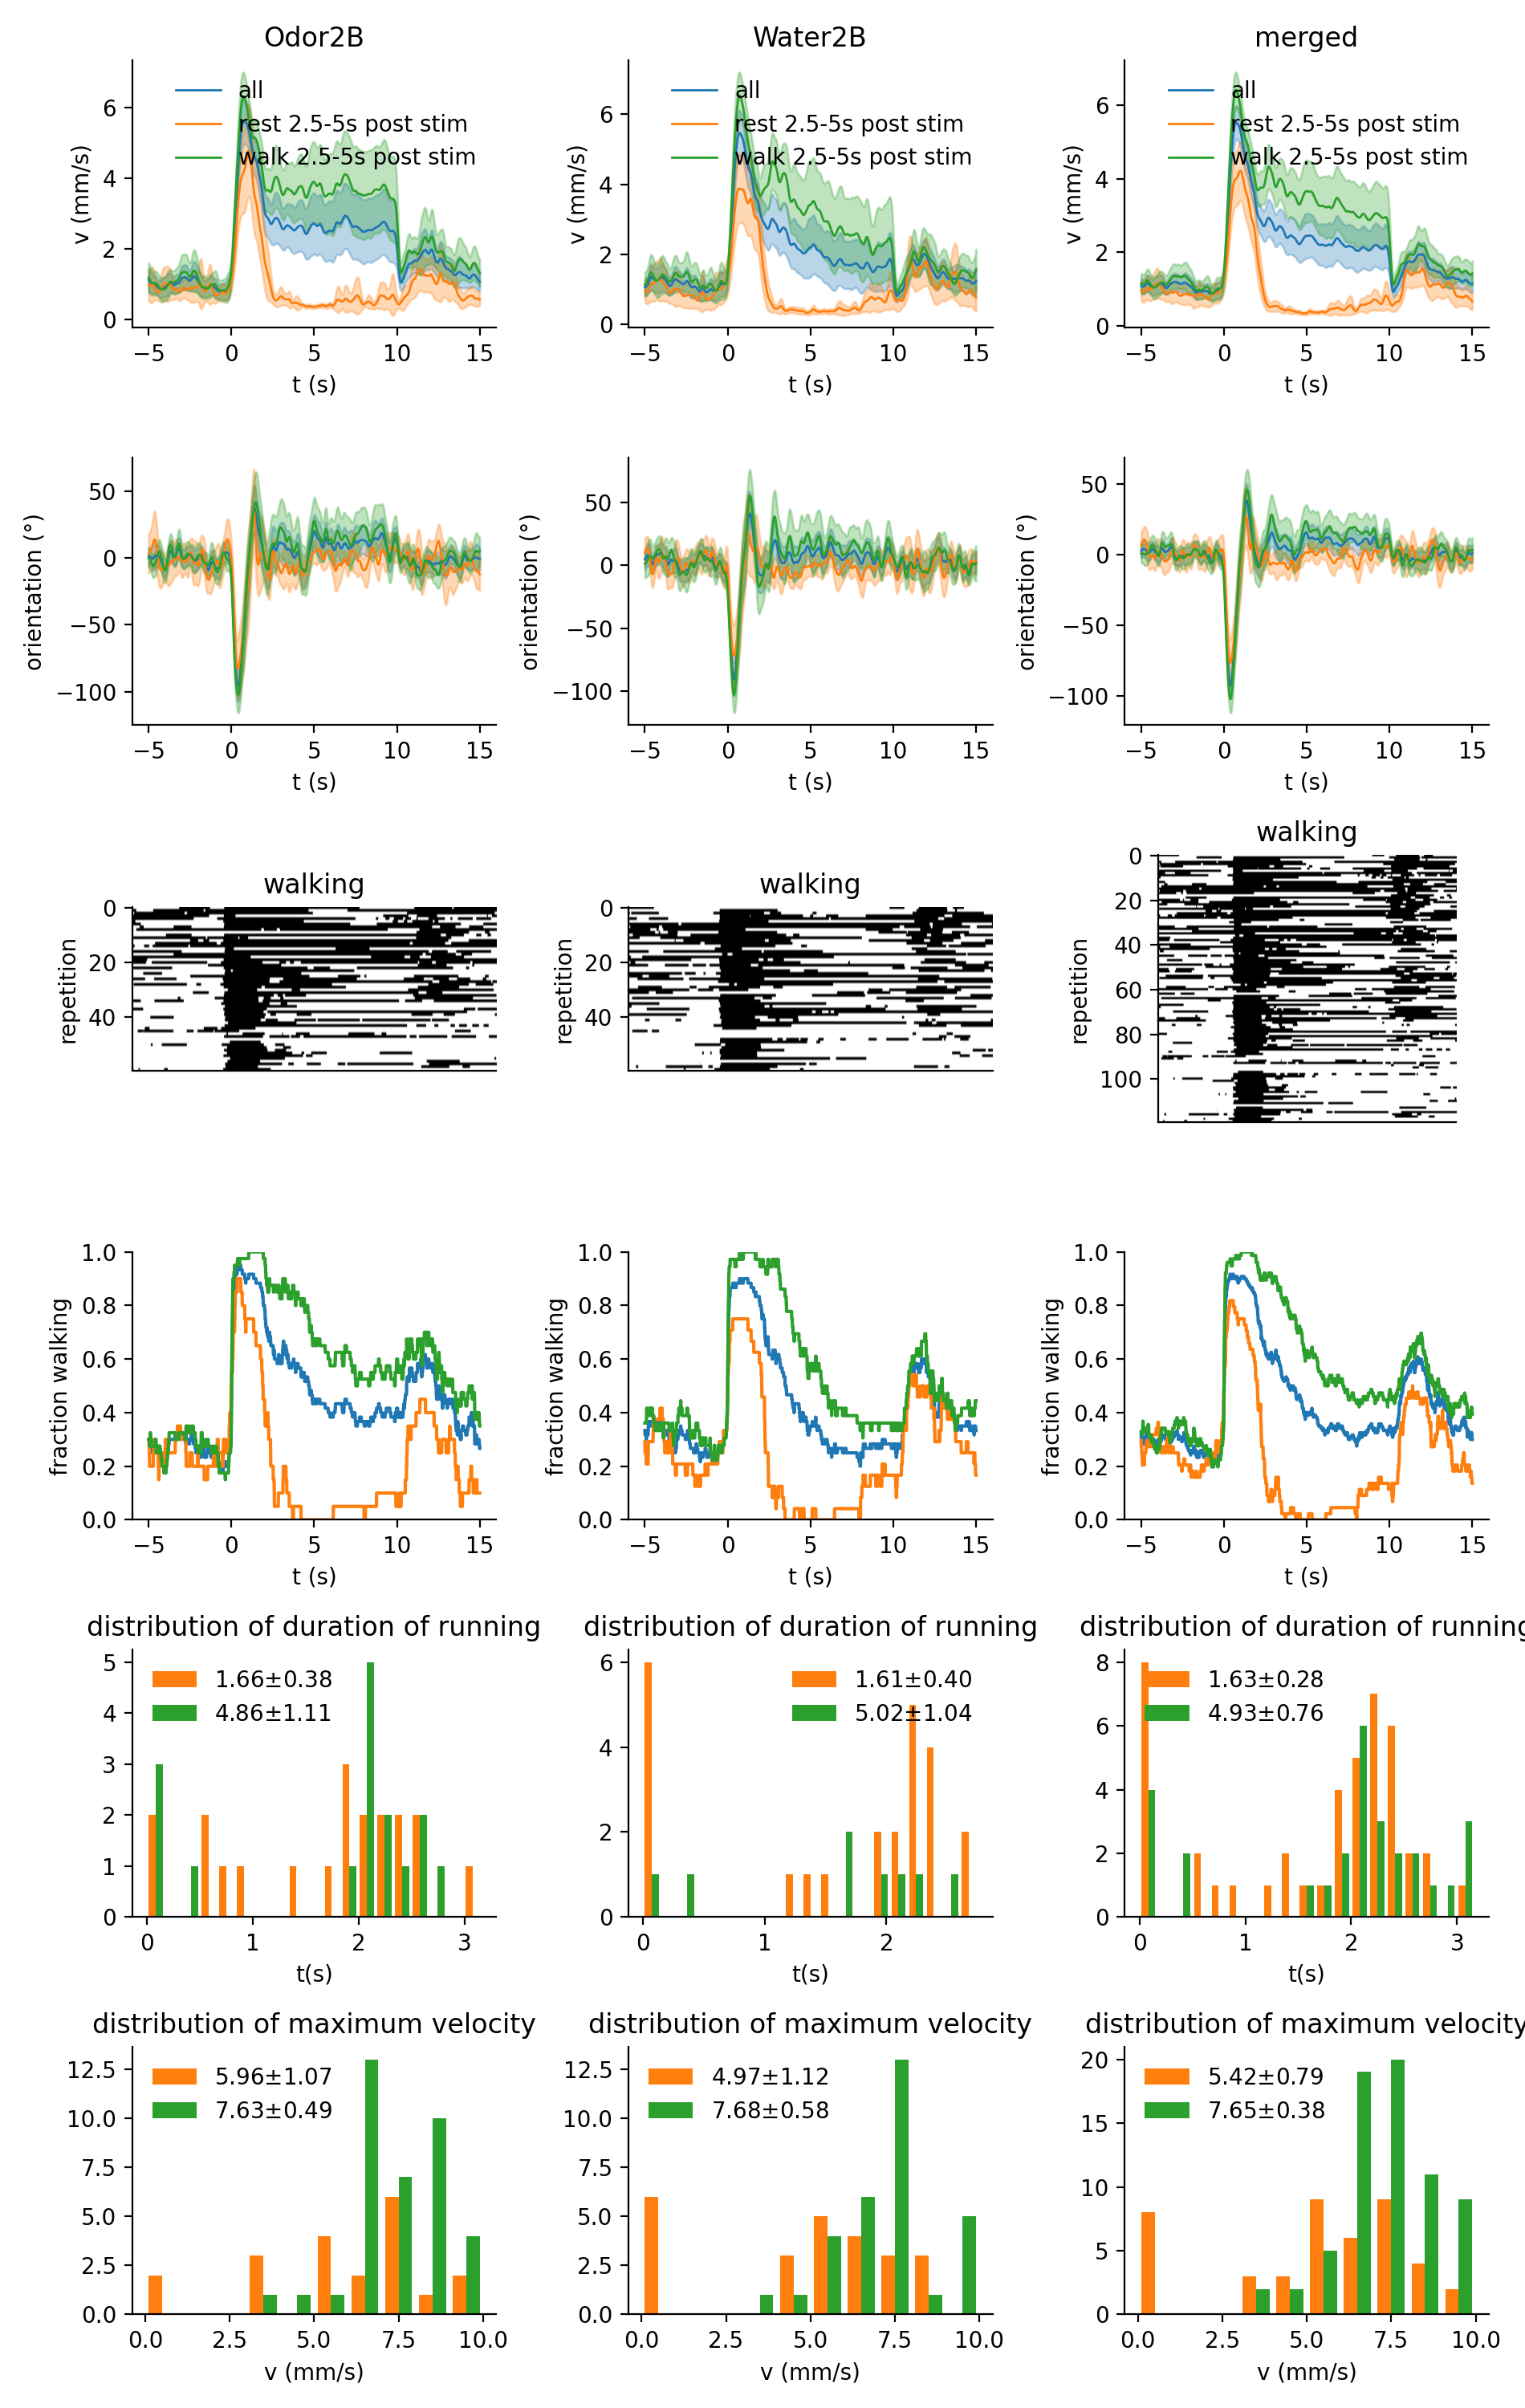

In [364]:
%matplotlib notebook
t = np.linspace(-5, 15, 2001)

fig, axs = plt.subplots(6,3, figsize=(9.5,15))

plot_responses(#[distribs_odour, distribs_odour_restbefore, distribs_odour_walkbefore], 
               [distribs_odour, distribs_odour_restmiddle, distribs_odour_walkmiddle], 
               axs[:,0], title="Odor2B", 
               #labels=["all", "rest before", "walk before"])
               labels=["all", "rest 2.5-5s post stim", "walk 2.5-5s post stim"])
plot_responses(#[distribs_water, distribs_water_restbefore, distribs_water_walkbefore], 
               [distribs_water, distribs_water_restmiddle, distribs_water_walkmiddle], 
               axs[:,1], title="Water2B", 
               #labels=["all", "rest before", "walk before"])
               labels=["all", "rest 2.5-5s post stim", "walk 2.5-5s post stim"])
plot_responses(#[distribs_merged, distribs_merged_restbefore, distribs_merged_walkbefore], 
               [distribs_merged, distribs_merged_restmiddle, distribs_merged_walkmiddle], 
               axs[:,2], title="merged", 
               #labels=["all", "rest before", "walk before"])
               labels=["all", "rest 2.5-5s post stim", "walk 2.5-5s post stim"])
fig.tight_layout()

<IPython.core.display.Javascript object>


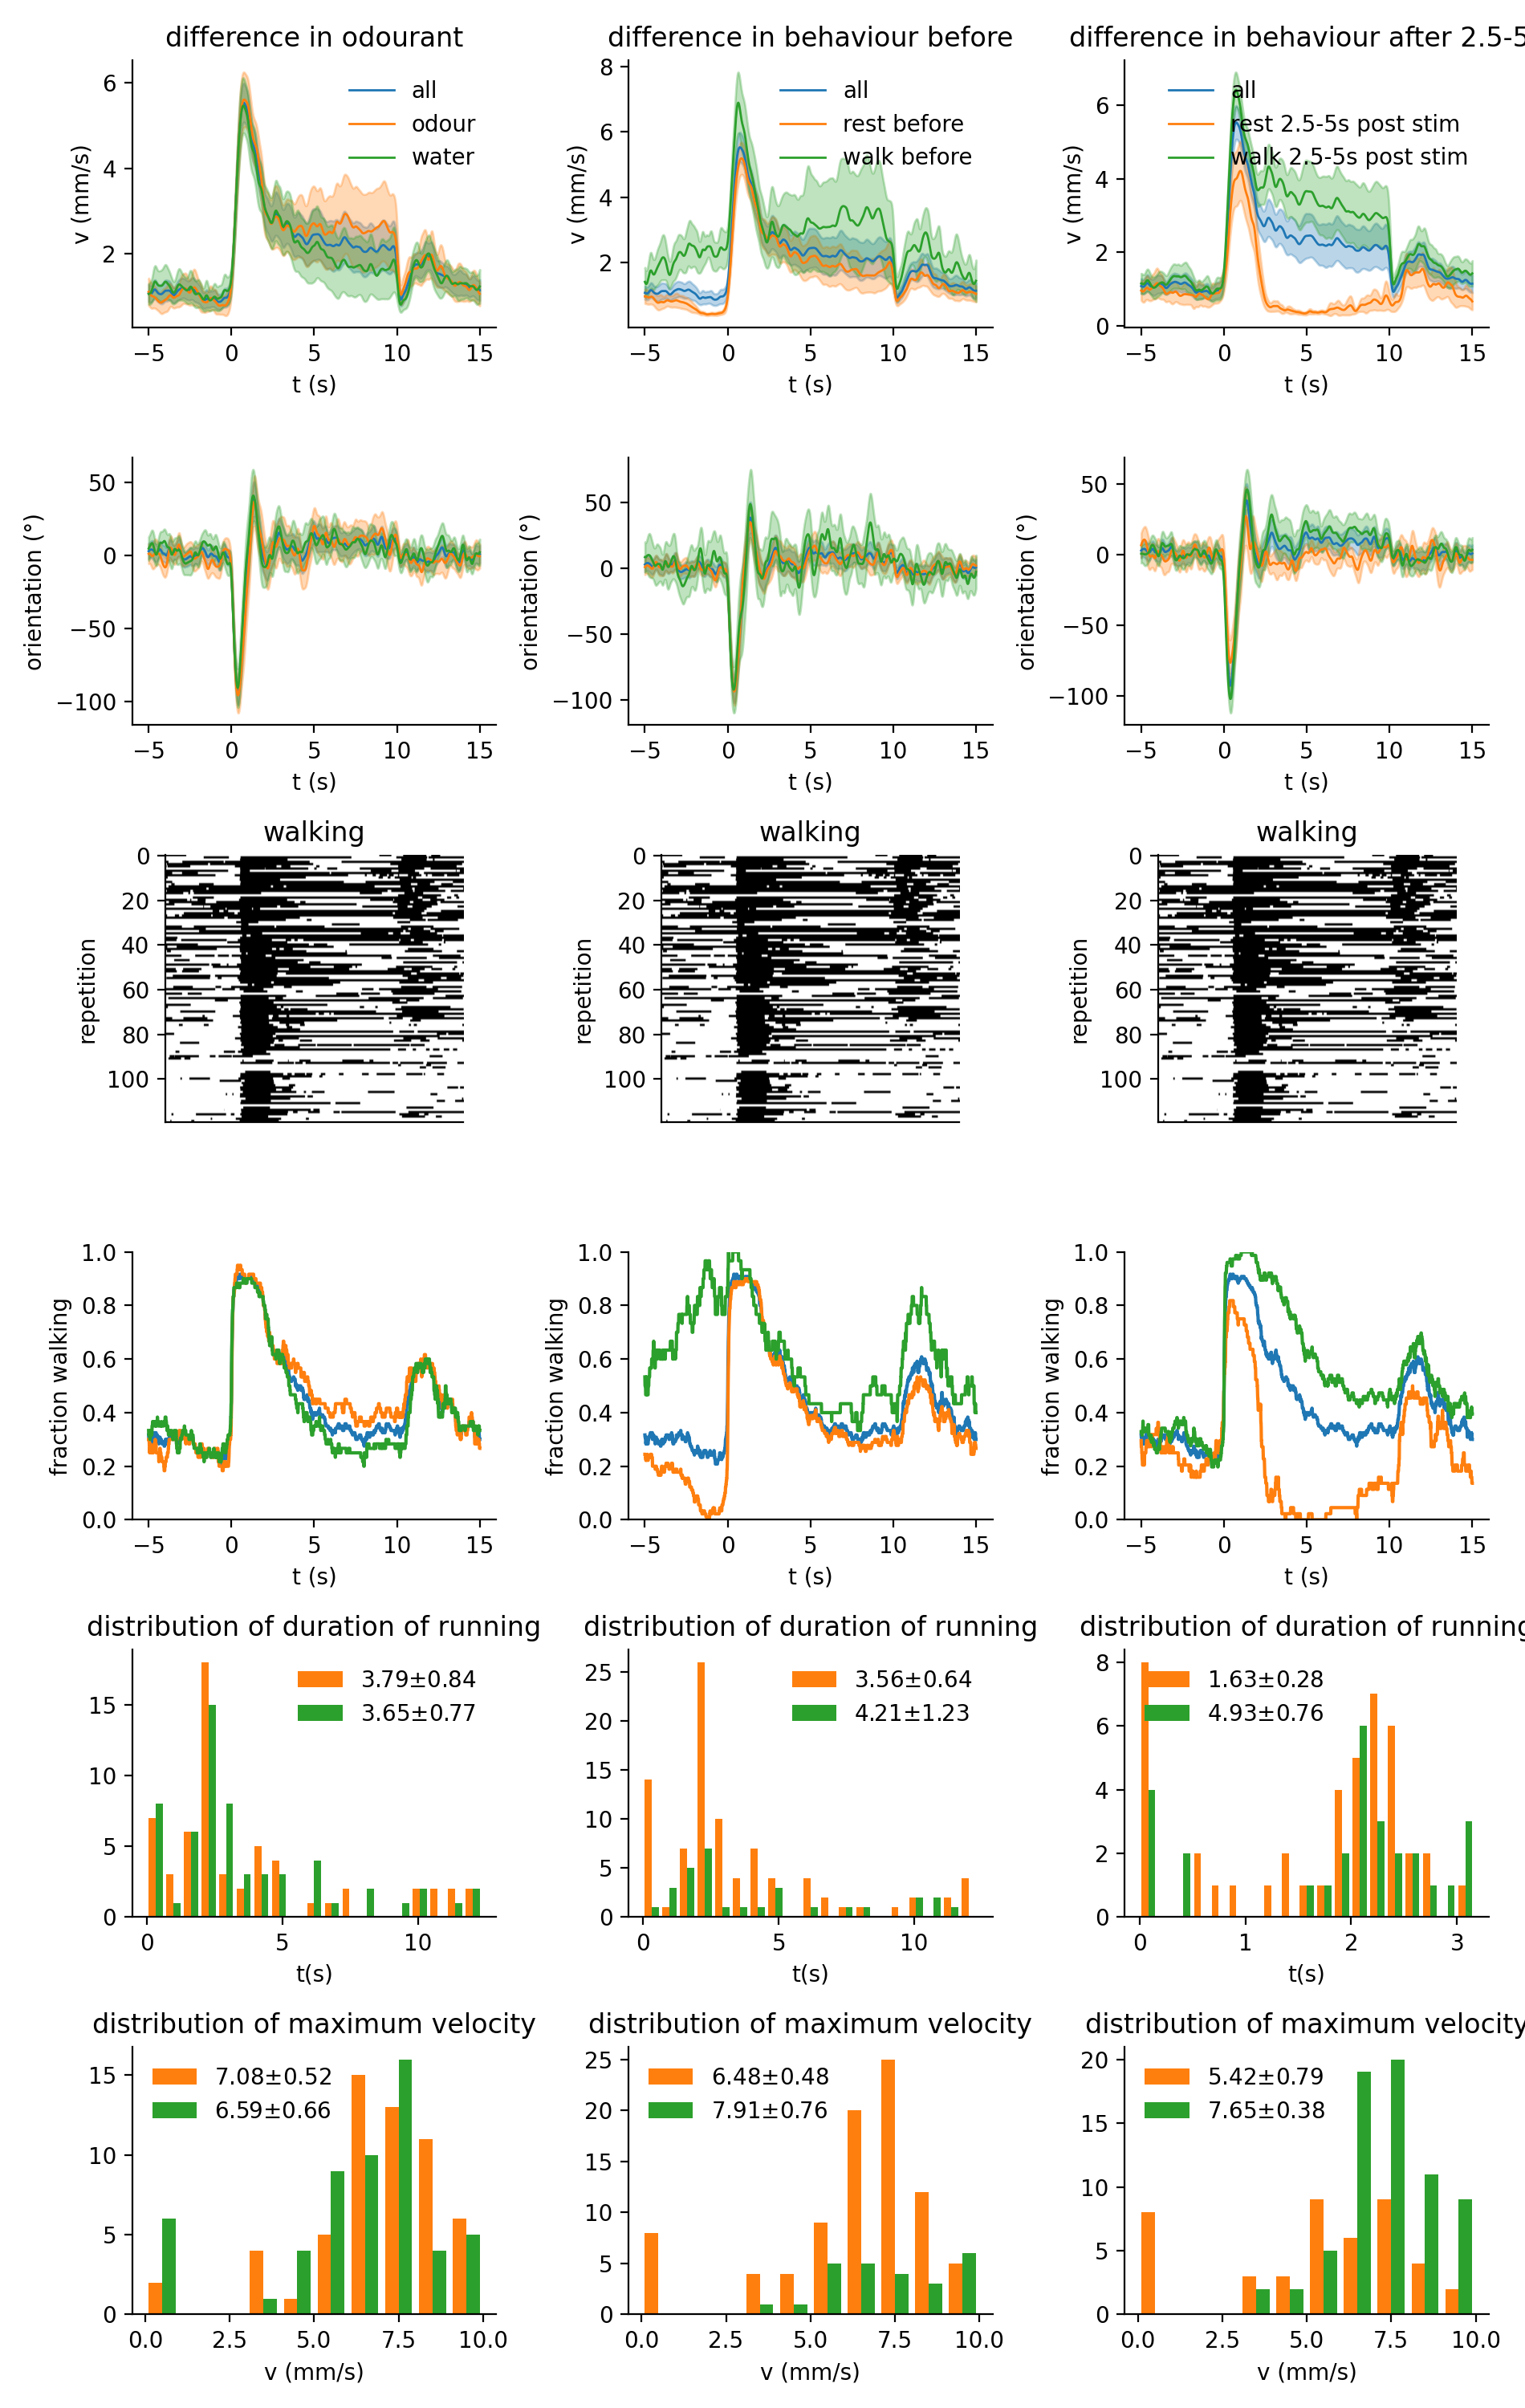

In [379]:
%matplotlib notebook
t = np.linspace(-5, 15, 2001)

fig, axs = plt.subplots(6,3, figsize=(9.5,15))

plot_responses([distribs_merged, distribs_odour, distribs_water], 
               axs[:,0], title="difference in odourant", 
               labels=["all", "odour", "water"])
plot_responses([distribs_merged, distribs_merged_restbefore, distribs_merged_walkbefore], 
               axs[:,1], title="difference in behaviour before", 
               labels=["all", "rest before", "walk before"])
plot_responses([distribs_merged, distribs_merged_restmiddle, distribs_merged_walkmiddle], 
               axs[:,2], title="difference in behaviour after 2.5-5s", 
               labels=["all", "rest 2.5-5s post stim", "walk 2.5-5s post stim"])
fig.tight_layout()

# Explaining variance with a linear model
## Explanans (X):
- odourant
- binary walking/resting before
- average velocity before in bins of 0.5s
- average orientation before in bins of 0.5s

## Explanandum (y):
- distribution of duration of running
- distribution of maximum velocity
- whether resting from 2.5-5s
- velocity at each time point after stimulus in bins of 0.5s
- orientation at each time point

In [374]:
from longterm.behaviour.synchronisation import reduce_during_2p_frame as reduce

In [380]:
velocities = np.array(condition_signals_merged[0][0])
orientations = np.array(condition_signals_merged[1][0])

In [433]:
fs=100
bin_size = 50
reduce_ind = np.array(np.arange(2001)/bin_size).astype(int)
velocities_reduced = reduce(reduce_ind, velocities.T).T
orientations_reduced = reduce(reduce_ind, orientations.T).T

In [595]:
state_before = (np.mean(velocities[:,250:500], axis=1, keepdims=True) > 1).astype(int)
odourant = np.array([c == "Odor2B" for c in conditions])[:, np.newaxis].astype(int)
state_after = (np.mean(velocities[:,750:1000], axis=1, keepdims=True) > 1).astype(int)

In [474]:
def standardise(array, axis=0):
    return (array - np.mean(array, axis=axis)) / np.std(array, axis=axis)

In [543]:
def shuffle_regressors(X, inds="all"):
    if inds == "all":
        inds = [True]*X.shape[1]
    if (isinstance(inds, list) or isinstance(inds, np.ndarray)) and len(inds) < X.shape[1]:
        inds = [True if i in inds else False for i in range(X.shape[1])]
    return np.hstack([np.random.choice(x, size=x.shape, replace=False)[:, np.newaxis] 
                      if i else x[:, np.newaxis] for x, i in zip(X.T, inds)])
    

In [657]:
def fit_regression(X,y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

In [658]:
def predict_regression(X,w):
    return X.dot(w)

In [659]:
def fit_predict(X,y):
    w = fit_regression(X,y)
    return predict_regression(X,w)

In [553]:
def var_exp(y, y_hat):
    return 1 - np.var(y-y_hat, axis=0)/np.var(y, axis=0)

In [555]:
def fit_predict_varexp(X, y):
    y_hat = fit_predict(X, y)
    return var_exp(y, y_hat)

In [630]:
t_ = np.arange(len(odourant))[:, np.newaxis]
t_poly = np.hstack((standardise(t_),
                    standardise(t_**2),
                    standardise(t_**3),
                    standardise(t_**4),
                    standardise(t_**5)))

In [636]:
X = np.hstack((t_poly,
               standardise(odourant),
               standardise(state_before),
               standardise(velocities_reduced[:,:10]),
               standardise(orientations_reduced[:,:10])))
X_names = ["t", r"$t^2$", r"$t^3$", r"$t^4$", r"$t^5$"] + \
          ["odourant", "behaviour before"] + \
          ["v:{}-{}s bef".format(t, t-bin_size/fs) for t in np.arange(5,0,-bin_size/fs)] + \
          ["ori:{}-{}s bef".format(t, t-bin_size/fs) for t in np.arange(5,0,-bin_size/fs)]
X_groups = [0]*5 + [1]*2 + [2]*10 + [3]*10
y = np.hstack((standardise(distribs_merged["run_times"][:, np.newaxis]),
               standardise(distribs_merged["v_max"][:, np.newaxis]),
               standardise(state_after),
               standardise(velocities_reduced[:,10:30]),
               standardise(orientations_reduced[:,10:30])))
y_names = ["run duration", "maximum velocity", "beh after 2.5s"] + \
          ["v:{}-{}s after".format(t, t+bin_size/fs) for t in np.arange(0,10,bin_size/fs)] + \
          ["ori:{}-{}s after".format(t, t+bin_size/fs) for t in np.arange(0,10,bin_size/fs)]




print(X.shape, y.shape)

(120, 27) (120, 43)


In [707]:
w = fit_regression(X, y)
y_hat = predict_regression(X, w)
print(w.shape)

(27, 43)


In [708]:
from sklearn.isotonic import IsotonicRegression
isotonic_fits = np.array([IsotonicRegression(increasing="auto").fit_transform(np.arange(len(y[:,i])),y[:,i]) 
                           for i in range(y.shape[1])]).T

/home/jbraun/anaconda3/envs/longterm37/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/home/jbraun/anaconda3/envs/longterm37/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/home/jbraun/anaconda3/envs/longterm37/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/home/jbraun/anaconda3/envs/longterm37/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient

<IPython.core.display.Javascript object>


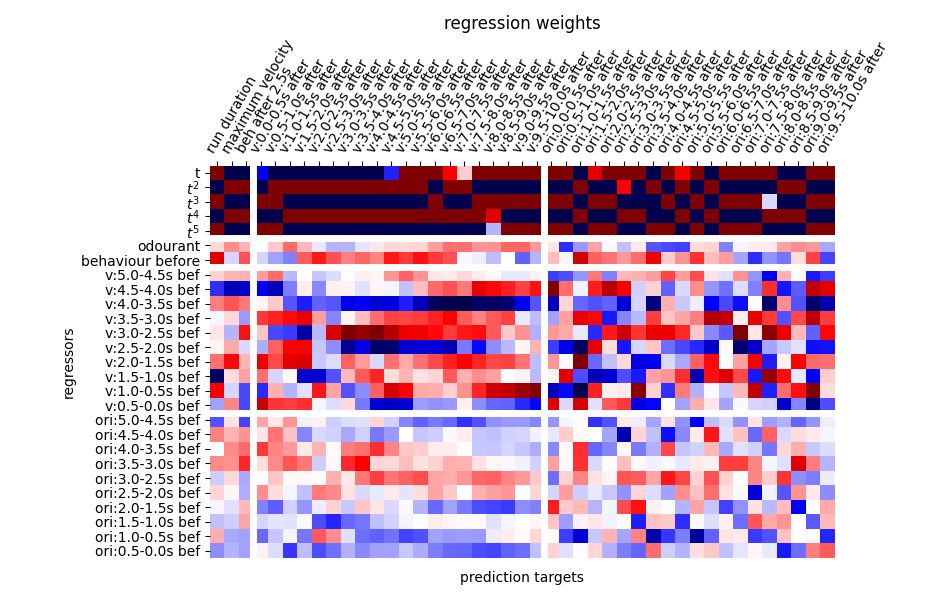

In [709]:
%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize=(9.5, 6))
ax.imshow(w, clim=[-0.5, 0.5], cmap=plt.cm.get_cmap("seismic"))
ax.set_yticks(np.arange(w.shape[0]))
ax.set_yticklabels(X_names)
ax.set_ylabel("regressors")
ax.set_xticks(np.arange(w.shape[1]))
ax.set_xticklabels(y_names)
ax.set_xlabel("prediction targets")
ax.set_title("regression weights")

ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=60, ha="left",
             rotation_mode="anchor")
ax.spines[:].set_visible(False)
ax.set_xticks(np.array([3,23])-.5, minor=True)
ax.set_yticks(np.array([5,7,17])-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=5)
ax.tick_params(which="minor", bottom=False, left=False)



fig.tight_layout()

## compute individual explained variances

<IPython.core.display.Javascript object>


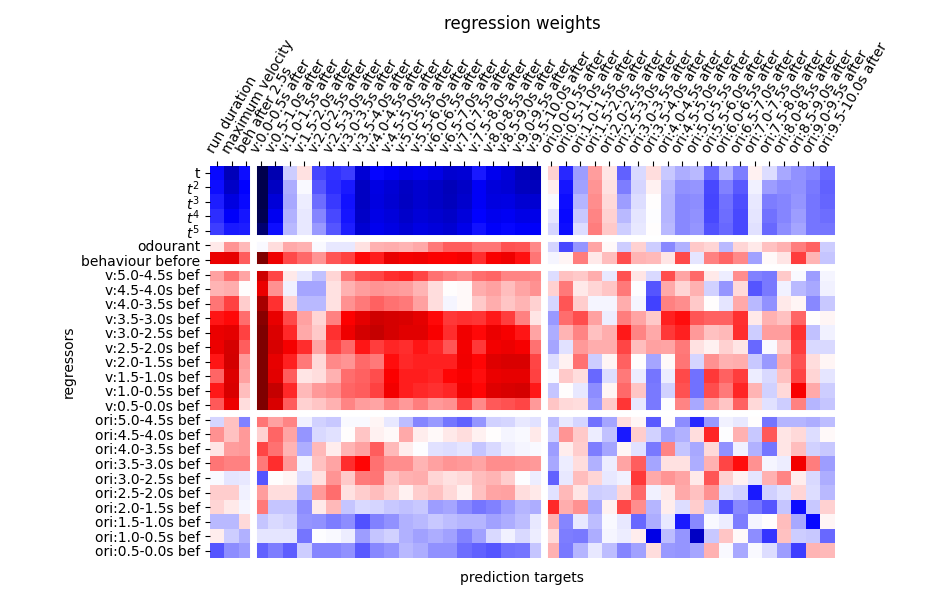

In [710]:
%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize=(9.5, 6))

cross_corr = X.T.dot(y) / len(X)

im = ax.imshow(cross_corr, clim=[-0.5, 0.5], cmap=plt.cm.get_cmap("seismic"))
ax.set_yticks(np.arange(cross_corr.shape[0]))
ax.set_yticklabels(X_names)
ax.set_ylabel("regressors")
ax.set_xticks(np.arange(cross_corr.shape[1]))
ax.set_xticklabels(y_names)
ax.set_xlabel("prediction targets")
ax.set_title("regression weights")

ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=60, ha="left",
             rotation_mode="anchor")
ax.spines[:].set_visible(False)
ax.set_xticks(np.array([3,23])-.5, minor=True)
ax.set_yticks(np.array([5,7,17])-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=5)
ax.tick_params(which="minor", bottom=False, left=False)

fig.tight_layout()

In [711]:
all_var_exps = []
X_shuffle = shuffle_regressors(X, inds="all")
this_var_exp = fit_predict_varexp(X_shuffle, y)
all_var_exps.append(this_var_exp)

this_var_exp = fit_predict_varexp(X, y)
all_var_exps.append(this_var_exp)

all_var_exps.append(var_exp(y, isotonic_fits))

for i_group in np.unique(X_groups):
    to_shuffle = X_groups != i_group
    X_shuffle = shuffle_regressors(X, inds=to_shuffle)
    this_var_exp = fit_predict_varexp(X_shuffle, y)
    all_var_exps.append(this_var_exp)

for i_x, x_name in enumerate(X_names):
    to_shuffle = np.ones((len(X_names))).astype(bool)
    to_shuffle[i_x] = False
    X_shuffle = shuffle_regressors(X, inds=to_shuffle)
    this_var_exp = fit_predict_varexp(X_shuffle, y)
    all_var_exps.append(this_var_exp)
    
all_var_exps = np.array(all_var_exps)

/home/jbraun/anaconda3/envs/longterm37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [642]:
len(all_var_exps)

33

<IPython.core.display.Javascript object>


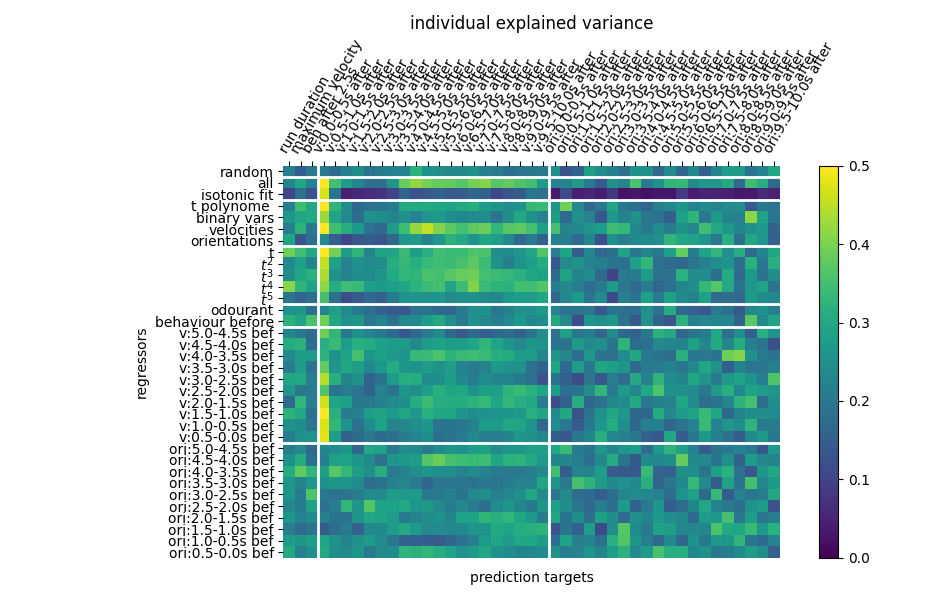

In [712]:
%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize=(9.5, 6))

im = ax.imshow(all_var_exps, clim=[0, 0.5])


ax.set_yticks(np.arange(all_var_exps.shape[0]))
ax.set_yticklabels(["random", "all", "isotonic fit"] + ["t polynome ", "binary vars", "velocities", "orientations"] + X_names)
ax.set_ylabel("regressors")
ax.set_xticks(np.arange(all_var_exps.shape[1]))
ax.set_xticklabels(y_names)
ax.set_xlabel("prediction targets")

ax.set_title("individual explained variance")

ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=60, ha="left",
             rotation_mode="anchor")
ax.spines[:].set_visible(False)
ax.set_yticks(np.array([1,3,7,12,14,24])-.5, minor=True)
ax.set_xticks(np.array([3,23])-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.tick_params(which="minor", bottom=False, left=False)

fig.colorbar(im)

fig.tight_layout()

In [713]:
frac_all_var_exps = all_var_exps / all_var_exps[1,:]

<IPython.core.display.Javascript object>


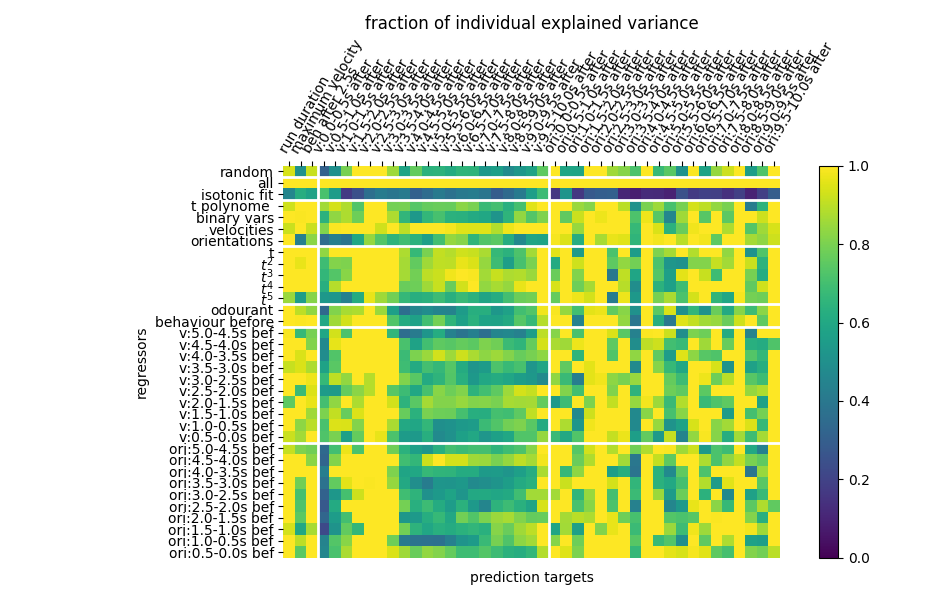

In [714]:
%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize=(9.5, 6))

im = ax.imshow(frac_all_var_exps, clim=[0, 1])


ax.set_yticks(np.arange(frac_all_var_exps.shape[0]))
ax.set_yticklabels(["random", "all", "isotonic fit"] + ["t polynome ", "binary vars", "velocities", "orientations"] + X_names)
ax.set_ylabel("regressors")
ax.set_xticks(np.arange(frac_all_var_exps.shape[1]))
ax.set_xticklabels(y_names)
ax.set_xlabel("prediction targets")

ax.set_title("fraction of individual explained variance")

ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=60, ha="left",
             rotation_mode="anchor")
ax.spines[:].set_visible(False)
ax.set_yticks(np.array([1,3,7,12,14,24])-.5, minor=True)
ax.set_xticks(np.array([3,23])-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.tick_params(which="minor", bottom=False, left=False)

fig.colorbar(im)

fig.tight_layout()

## compute unique explained variances

In [715]:
all_var_exps_unique = []
X_shuffle = shuffle_regressors(X, inds="all")
this_var_exp = fit_predict_varexp(X_shuffle, y)
all_var_exps_unique.append(this_var_exp)

this_var_exp_allX = fit_predict_varexp(X, y)
all_var_exps_unique.append(this_var_exp_allX)

all_var_exps_unique.append(var_exp(y, isotonic_fits))



for i_group in np.unique(X_groups):
    to_shuffle = X_groups == i_group
    X_shuffle = shuffle_regressors(X, inds=to_shuffle)
    this_var_exp = fit_predict_varexp(X_shuffle, y)
    all_var_exps_unique.append(this_var_exp_allX-this_var_exp)

for i_x, x_name in enumerate(X_names):
    to_shuffle = np.zeros((len(X_names))).astype(bool)
    to_shuffle[i_x] = True
    X_shuffle = shuffle_regressors(X, inds=to_shuffle)
    this_var_exp = fit_predict_varexp(X_shuffle, y)
    all_var_exps_unique.append(this_var_exp_allX-this_var_exp)
    
all_var_exps_unique = np.array(all_var_exps_unique)

/home/jbraun/anaconda3/envs/longterm37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


<IPython.core.display.Javascript object>


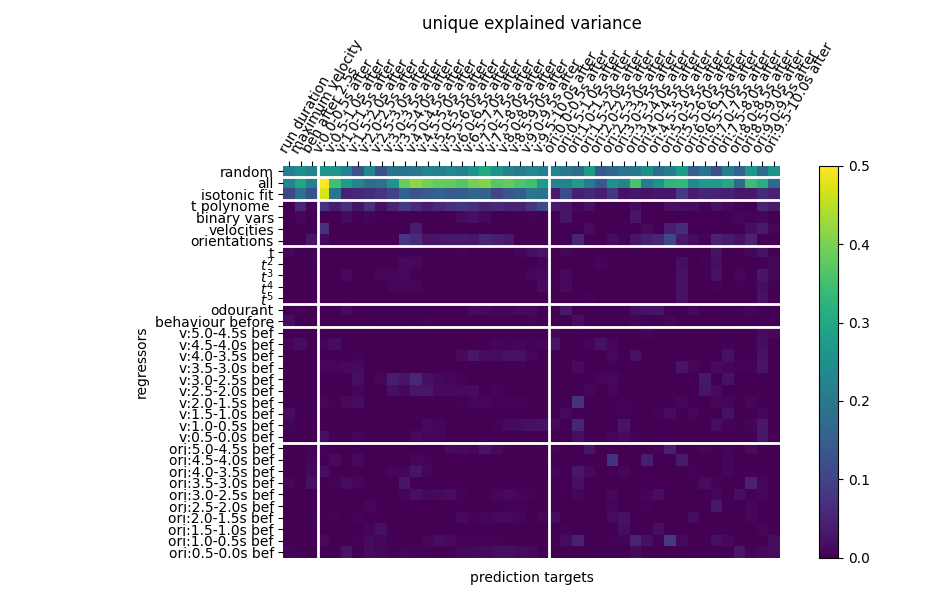

In [716]:
%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize=(9.5, 6))

im = ax.imshow(all_var_exps_unique, clim=[0, 0.5])


ax.set_yticks(np.arange(all_var_exps_unique.shape[0]))
ax.set_yticklabels(["random", "all", "isotonic fit"] + ["t polynome ", "binary vars", "velocities", "orientations"] + X_names)
ax.set_ylabel("regressors")
ax.set_xticks(np.arange(all_var_exps_unique.shape[1]))
ax.set_xticklabels(y_names)
ax.set_xlabel("prediction targets")

ax.set_title("unique explained variance")

ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=60, ha="left",
             rotation_mode="anchor")
ax.spines[:].set_visible(False)
ax.set_yticks(np.array([1,3,7,12,14,24])-.5, minor=True)
ax.set_xticks(np.array([3,23])-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.tick_params(which="minor", bottom=False, left=False)

fig.colorbar(im)

fig.tight_layout()

In [717]:
frac_all_var_exps_unique = all_var_exps_unique / all_var_exps_unique[1,:]

<IPython.core.display.Javascript object>


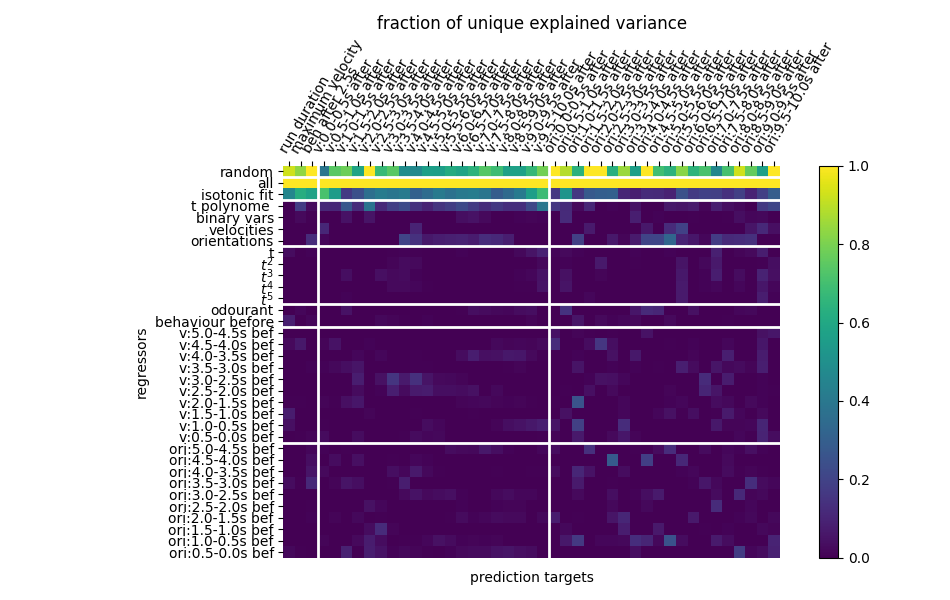

In [718]:
%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize=(9.5, 6))

im = ax.imshow(frac_all_var_exps_unique, clim=[0, 1])


ax.set_yticks(np.arange(frac_all_var_exps_unique.shape[0]))
ax.set_yticklabels(["random", "all", "isotonic fit"] + ["t polynome ", "binary vars", "velocities", "orientations"] + X_names)
ax.set_ylabel("regressors")
ax.set_xticks(np.arange(frac_all_var_exps_unique.shape[1]))
ax.set_xticklabels(y_names)
ax.set_xlabel("prediction targets")

ax.set_title("fraction of unique explained variance")

ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=60, ha="left",
             rotation_mode="anchor")
ax.spines[:].set_visible(False)
ax.set_yticks(np.array([1,3,7,12,14,24])-.5, minor=True)
ax.set_xticks(np.array([3,23])-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.tick_params(which="minor", bottom=False, left=False)

fig.colorbar(im)

fig.tight_layout()

## check polynomial coefficients

In [653]:
w.shape

(27, 43)

In [676]:
N_coeff = 5
poly_coeff = fit_regression(t_poly[:,:N_coeff], y)# w[:5,:]
polies = predict_regression(t_poly[:,:N_coeff], poly_coeff)

<IPython.core.display.Javascript object>


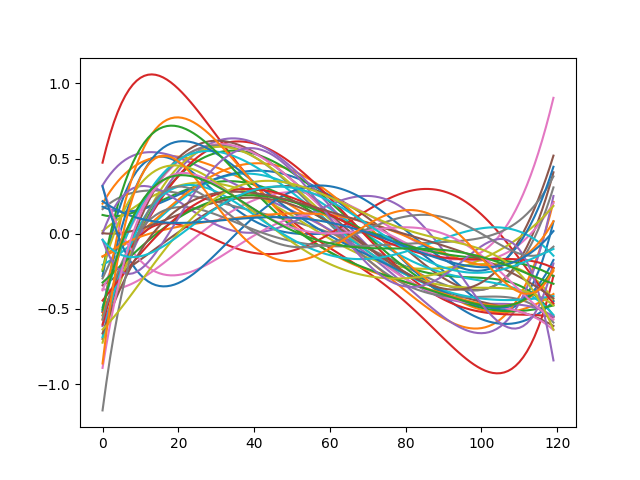

In [678]:
%matplotlib notebook
_ = plt.plot(polies)

In [694]:
from sklearn.isotonic import IsotonicRegression

In [703]:
isotonic_fits = np.array([IsotonicRegression(increasing="auto").fit_transform(np.arange(len(y[:,i])),y[:,i]) for i in range(y.shape[1])]).T

/home/jbraun/anaconda3/envs/longterm37/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/home/jbraun/anaconda3/envs/longterm37/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/home/jbraun/anaconda3/envs/longterm37/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/home/jbraun/anaconda3/envs/longterm37/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient

<IPython.core.display.Javascript object>


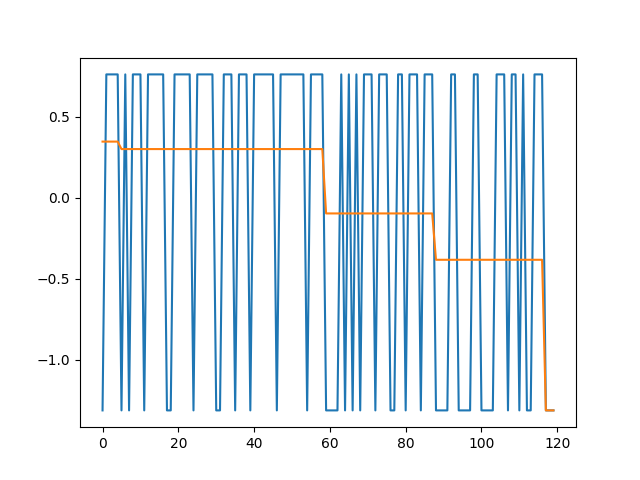

In [704]:
%matplotlib notebook
_ = plt.plot(y[:,2:3])
_ = plt.plot(isotonic_fits[:,2:3])  # [:,1:2])

In [706]:
np.mean(var_exp(y, isotonic_fits))

0.10135480504457489